In [32]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [33]:
!nvidia-smi

Fri Sep 18 08:14:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:37:00.0 Off |                  Off |
| 31%   43C    P2    36W / 250W |   2811MiB / 32508MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

loss        0.021494
val_loss    0.055895
dtype: float64
loss        0.022744
val_loss    0.040856
dtype: float64


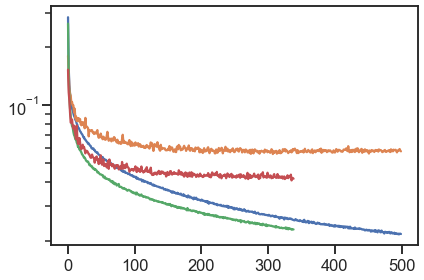

In [34]:
log = pd.read_csv('20200917_redox_atomwise/log.csv').set_index('epoch')

plt.semilogy(log.loss)
plt.semilogy(log.val_loss)
    
print(log.min())

log = pd.read_csv('20200918_redox_atomwise/log.csv').set_index('epoch')

plt.semilogy(log.loss)
plt.semilogy(log.val_loss)

print(log.min())

plt.tight_layout()
# plt.xlim([0, 10])

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [36]:
from preprocess_inputs import preprocessor
preprocessor.from_json('tfrecords/preprocessor.json')

from loss import AtomInfMask, KLWithLogits, RedoxAttention
from nfp import EdgeUpdate, NodeUpdate, GlobalUpdate
import tensorflow_addons as tfa

model = tf.keras.models.load_model(
    '20200918_redox_atomwise/best_model.hdf5',
    custom_objects={**nfp.custom_objects,
                    **{'EdgeUpdate': EdgeUpdate,
                       'NodeUpdate': NodeUpdate,
                       'GlobalUpdate': GlobalUpdate}})

In [69]:
redox_df = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/redox_data.csv.gz')

In [70]:
redox_df.notna().sum(0)

smiles               77925
ionization energy    44274
electron affinity    73684
oxidized_s2           2077
reduced_s2             174
reduced_rms          74348
oxidized_rms         45062
dtype: int64

In [71]:
data = np.load('redox_split.npz', allow_pickle=True)
redox_valid = redox_df[redox_df.smiles.isin(np.concatenate([data['valid'], data['test']]))]

In [72]:
redox_valid.shape

(1837, 7)

In [73]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in redox_valid.smiles),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(),
                  padding_values=preprocessor.padding_values)

In [74]:
predicted_redox = model.predict(test_dataset, verbose=1)

15/15 [==============================] - 2s 132ms/step


Text(0.5, 1.0, 'electron affinity')

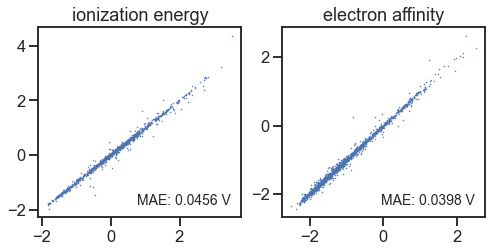

In [75]:
fig, axs = plt.subplots(ncols=2, figsize=(8,3.5))
axs[0].plot(redox_valid['ionization energy'], predicted_redox[:, 0], '.', ms=1)
axs[1].plot(redox_valid['electron affinity'], predicted_redox[:, 1], '.', ms=1)

axs[0].text(.95, .05, f"MAE: {(redox_valid['ionization energy'] - predicted_redox[:, 0]).abs().mean():.4f} V", ha='right', va='bottom', transform=axs[0].transAxes, fontsize=14)
axs[1].text(.95, .05, f"MAE: {(redox_valid['electron affinity'] - predicted_redox[:, 1]).abs().mean():.4f} V", ha='right', va='bottom', transform=axs[1].transAxes, fontsize=14)

axs[0].set_title('ionization energy')
axs[1].set_title('electron affinity')

In [76]:
redox_valid = redox_valid.copy()
redox_valid['pred ionization energy'] = predicted_redox[:, 0]
redox_valid['pred electron affinity'] = predicted_redox[:, 1]

In [77]:
redox_valid['err ionization energy'] = (redox_valid['pred ionization energy'] - redox_valid['ionization energy']).abs()
redox_valid['err electron affinity'] = (redox_valid['pred electron affinity'] - redox_valid['electron affinity']).abs()

<AxesSubplot:ylabel='Frequency'>

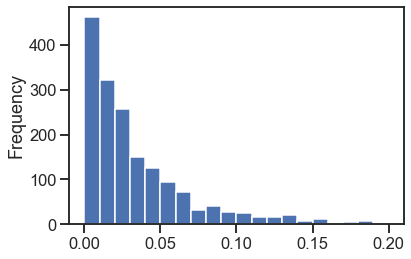

In [89]:
redox_valid['err electron affinity'].plot.hist(range=(0, .2), bins=20)

In [91]:
redox_valid['err ionization energy'].median()

0.024738154758599917

In [90]:
redox_valid['err electron affinity'].median()

0.023132014298559156

In [78]:
spins = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/redf_spins_expanded.csv.gz')

In [79]:
spins['fractional_spin'] = spins.groupby('smiles').spin.apply(lambda x: x.abs() / x.abs().sum())

In [80]:
max_fractional_spin = spins.groupby('smiles').fractional_spin.max()

In [81]:
redox_valid_spin = redox_valid.join(max_fractional_spin, on='smiles')

Text(0.5, 1.0, 'Electron Affinity')

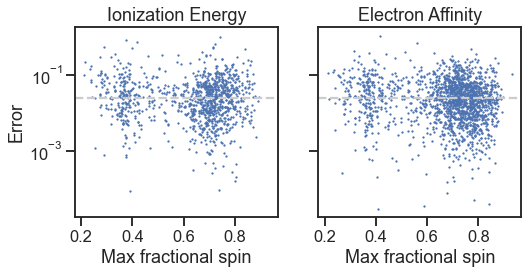

In [82]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5), sharey=True, sharex=True)
axs[0].semilogy(redox_valid_spin['fractional_spin'], redox_valid_spin['err ionization energy'], '.', ms=2.5)
axs[0].axhline(0.025, ls='--', color='.8')
axs[1].semilogy(redox_valid_spin['fractional_spin'], redox_valid_spin['err electron affinity'], '.', ms=2.5)
axs[1].axhline(0.025, ls='--', color='.8')

axs[0].set_ylabel('Error')
axs[0].set_xlabel('Max fractional spin')
axs[1].set_xlabel('Max fractional spin')

axs[0].set_title('Ionization Energy')
axs[1].set_title('Electron Affinity')

In [84]:
ie_outliers = redox_valid_spin[redox_valid_spin['fractional_spin'] > 0.75].sort_values('err ionization energy', ascending=False).head(3)
ea_outliers = redox_valid_spin[redox_valid_spin['fractional_spin'] > 0.70].sort_values('err electron affinity', ascending=False).head(3)

In [56]:
import psycopg2

dbparams = {
    'dbname': 'bde',
    'port': 5432,
    'host': 'yuma.hpc.nrel.gov',
    'user': 'bdeops',
    'password': 'BD30ps99!',
    'options': f'-c search_path=bde',
}

with psycopg2.connect(**dbparams) as conn:

    redf = pd.read_sql_query("""
    SELECT * from redoxcompound where status='finished'
    """, conn)

In [58]:
ie_outliers[['smiles', 'ionization energy', 'pred ionization energy', 'fractional_spin']]  # oxidized

,smiles,ionization energy,pred ionization energy,fractional_spin
61598,O=C1O[C]=C(O)[C@@H]1O,1.515234,1.998724,0.840871
32271,CC[C@@H]1[C]=C(C)OC1=O,2.257219,1.960669,0.807113
12942,C=[C]/C(C)=C/CO,-0.024437,0.232254,0.751129
76004,[CH2][C@@H]1C(=O)O[C@@H]2O[C@@H]21,1.494363,1.252732,0.851178
80376,[CH]1OCCOCOCO1,-0.609932,-0.845242,0.862178


In [60]:
ea_outliers[['smiles', 'electron affinity', 'pred electron affinity', 'fractional_spin']] 

,smiles,electron affinity,pred electron affinity,fractional_spin
15284,CC(=O)CC/C=[C]/C=O,-0.226205,0.244139,0.772311
2883,C/C=C/C=C(\C)C([O])=O,1.944104,1.588787,0.790588
46056,CS(=O)(=O)N1CC[CH]O1,-1.484461,-1.216699,0.756008
48557,C[C@@H]1N[CH]NC(=O)N1,-1.675672,-1.938326,0.785657
57775,N=C(N)[S],0.682718,0.428527,0.866395


In [61]:
import rdkit

In [62]:
ie_logs = redf[redf.smiles.isin(ie_outliers.smiles) & redf.estate.isin(('radical', 'oxidized'))].logfile
ea_logs = redf[redf.smiles.isin(ea_outliers.smiles) & redf.estate.isin(('radical', 'reduced'))].logfile

In [65]:
redf[redf.smiles.isin(ie_outliers.smiles) & redf.estate.isin(('radical', 'oxidized'))].sort_values(['smiles', 'estate'])

,id,cid,smiles,estate,type,run,status,enthalpy,freeenergy,mol_initial,mol_final,run_at,queued_at,logfile,error,node
85124,670571,504656,C=[C]/C(C)=C/CO,oxidized,None,10,finished,-308.840234,-308.882919,504656\n RDKit 3D\n\n 16 15 0 0...,670571\n RDKit 3D\n\n 16 15 0 0...,2020-09-06 23:23:49.984291,2020-09-06 23:06:53.691739,/projects/rlmolecule/pstjohn/redox_calculation...,None,r6i0n20
76359,670570,504656,C=[C]/C(C)=C/CO,radical,None,10,finished,-308.994876,-309.039348,504656\n RDKit 3D\n\n 16 15 0 0...,670570\n RDKit 3D\n\n 16 15 0 0...,2020-09-06 23:19:07.532071,2020-09-06 23:06:53.553486,/projects/rlmolecule/pstjohn/redox_calculation...,None,r6i2n8
200906,854879,291918,CC[C@@H]1[C]=C(C)OC1=O,oxidized,None,10,finished,-422.109475,-422.155447,291918\n RDKit 3D\n\n 18 18 0 0...,854879\n RDKit 3D\n\n 18 18 0 0...,2020-09-14 02:04:46.740888,2020-09-14 01:14:40.343903,/projects/rlmolecule/pstjohn/redox_calculation...,None,r6i0n23
197399,854878,291918,CC[C@@H]1[C]=C(C)OC1=O,radical,None,10,finished,-422.350976,-422.395727,291918\n RDKit 3D\n\n 18 18 0 0...,854878\n RDKit 3D\n\n 18 18 0 0...,2020-09-14 01:32:45.549037,2020-09-14 01:14:37.282770,/projects/rlmolecule/pstjohn/redox_calculation...,None,r6i0n15
144860,769220,49663,O=C1O[C]=C(O)[C@@H]1O,oxidized,None,10,finished,-454.735386,-454.775250,49663\n RDKit 3D\n\n 11 11 0 0 ...,769220\n RDKit 3D\n\n 11 11 0 0...,2020-09-10 04:18:33.343894,2020-09-10 03:52:22.051503,/projects/rlmolecule/pstjohn/redox_calculation...,None,r6i0n35
144855,769219,49663,O=C1O[C]=C(O)[C@@H]1O,radical,None,10,finished,-454.947381,-454.988262,49663\n RDKit 3D\n\n 11 11 0 0 ...,769219\n RDKit 3D\n\n 11 11 0 0...,2020-09-10 04:08:26.187140,2020-09-10 03:52:20.944238,/projects/rlmolecule/pstjohn/redox_calculation...,None,r6i3n1
30120,790859,466218,[CH2][C@@H]1C(=O)O[C@@H]2O[C@@H]21,oxidized,None,10,finished,-418.816233,-418.854634,466218\n RDKit 3D\n\n 13 14 0 0...,790859\n RDKit 3D\n\n 13 14 0 0...,2020-09-10 22:23:14.425572,2020-09-10 22:12:09.478168,/projects/rlmolecule/pstjohn/redox_calculation...,None,r6i6n15
112957,790858,466218,[CH2][C@@H]1C(=O)O[C@@H]2O[C@@H]21,radical,None,10,finished,-419.027115,-419.066879,466218\n RDKit 3D\n\n 13 14 0 0...,790858\n RDKit 3D\n\n 13 14 0 0...,2020-09-10 22:25:02.853996,2020-09-10 22:12:06.355294,/projects/rlmolecule/pstjohn/redox_calculation...,None,r6i3n28
26981,25997,511844,[CH]1OCCOCOCO1,oxidized,None,1,finished,-496.464716,-496.505764,511844\n RDKit 3D\n\n 18 18 0 0...,25997\n RDKit 3D\n\n 18 18 0 0 ...,2020-06-12 21:57:23.007362,2020-06-12 21:36:20.669668,/projects/rlmolecule/pstjohn/redox_calculation...,,r3i2n35
14301,25996,511844,[CH]1OCCOCOCO1,radical,None,1,finished,-496.598743,-496.640676,511844\n RDKit 3D\n\n 18 18 0 0...,25996\n RDKit 3D\n\n 18 18 0 0 ...,2020-06-12 21:56:42.289670,2020-06-12 21:36:19.062129,/projects/rlmolecule/pstjohn/redox_calculation...,,r3i2n26


In [68]:
print(redf.loc[144855].mol_final)

769219
     RDKit          3D

 11 11  0  0  0  0  0  0  0  0999 V2000
   -2.2620    0.8908    0.8367 O   0  0  0  0  0  0  0  0  0  0  0  0
   -1.4167    0.1219    0.5090 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.5233   -1.2300    0.7553 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.3245   -1.7923    0.3703 C   0  0  0  0  0  3  0  0  0  0  0  0
    0.5644   -0.9715   -0.1488 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.7845   -1.2431   -0.6621 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0834    0.3927   -0.1957 C   0  0  2  0  0  0  0  0  0  0  0  0
    0.6715    1.3805    0.4553 O   0  0  0  0  0  0  0  0  0  0  0  0
    2.3146   -0.4329   -0.6660 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.2965    0.6693   -1.2335 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.5714    2.2145   -0.0203 H   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  2  0
  2  3  1  0
  3  4  1  0
  4  5  2  0
  5  6  1  0
  5  7  1  0
  7  8  1  0
  7  2  1  0
  6  9  1  0
  7 10  1  6
  8 11  1  0
M  RAD  1   4   

In [ ]:
import shutil

In [ ]:
for log in ie_logs:
    shutil.copy(log, '/home/pstjohn/Research/20200608_redox_calculations/spin_gnn/20200917_outliers/ie')

In [ ]:
for log in ea_logs:
    shutil.copy(log, '/home/pstjohn/Research/20200608_redox_calculations/spin_gnn/20200917_outliers/ea')

In [ ]:
log

In [ ]:
import os


In [ ]:
ie_logs

In [ ]:
ie_logs.apply(os.path.basename)